# Are GNNs Overkill?
In this notebook I explore the prediction of molecular properties through a vision learner. In the field of molecular property prediction with machine learning, Graph Neural Networks (GNNs) are king. GNNs are Neural Networks that intrinsically use the Graph-like structure of molecules to form predictions of their properties. But how far can we get by just using pictures of molecules and applying a vision learner?

Here we explore the MUTAG dataset which is a dataset of 188 molecular graphs with the label whether they are poisonous or not. We first apply a vision learner to pictures of the molecules and then a GNN to the graphs and compare prediction results on whether they are poisonous or not

## 0) Import packages
torch geometric is the important one here

In [1]:
# %% Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib import cm
import os
# deep learning packages
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
# Import MUTAG
from torch_geometric.datasets import TUDataset
# to visualise
from torch_geometric.utils import to_networkx
import networkx as nx
# fastai
from fastai.vision.all import *
from fastai.metrics import accuracy
#  to batch
from torch_geometric.loader import DataLoader

/Users/tammodukker/opt/anaconda3/envs/venv_Graph_1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Let's load in the MUTAG dataset and explore it a bit

In [2]:
#Get data
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Inspect a graph
data = dataset[0]  # Get the first graph object.
print('\n')
print(data)
print('=============================================================')
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of node features: 7
Number of classes: 2


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


## 1) Lets create a train and test set so that we can compare performance of both models (the vision learner & GNN) on the same test set

In [3]:
#Create train & test dataset
torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 150
Number of test graphs: 38


# 2) Vision learner 

### 2.1) Now in order to apply the vision learner we need to transform the molecular graph structures into pictures

In [4]:
def create_image_from_graph(graph, train_or_test, num_molecule):
    '''
    Here we can to create a picture of the graph structure. Each unique atom in the molecule we want
    to give a seperate colour

    graph = the graph one turns into an image
    train_or_test = is this graph part of the train or test set
    num_molecule = identifier of the graph such that we can save as unique images 
    '''
    # get the node features of the graph
    features = graph.x.numpy()

    # Create a color map for unique feature vectors
    unique_features = []
    # Generate each vector with a single '1' at increasing indices
    num_features = data.num_node_features
    for i in range(num_features):
        vector = np.zeros(num_features, dtype=int)
        vector[i] = 1
        unique_features.append(vector)  # Find unique feature vectors

    # Create a colormap
    cmap = cm.get_cmap('tab20', num_features)  # Adjust colormap if needed
    colors_map = {tuple(fv): to_hex(cmap(i / num_features)) for i, fv in enumerate(unique_features)}

    # Map node features to colors
    def get_node_colors(features, color_map):
        colors = [color_map.get(tuple(fv), '#000000') for fv in features]
        return colors
    
    G = to_networkx(graph, to_undirected=True)
    # Apply the color map to the current graph
    node_colors = get_node_colors(features, colors_map)

    plt.figure(figsize=(7,5))
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors, with_labels=True)
    
    # Ensure the directories exist before saving the files
    if graph.y == 1:
        directory = 'poisonous'
    elif graph.y == 0:
        directory = 'non-poisonous'
    else:
        return  # Handle unexpected cases

    # Create the directory if it does not exist
    if not os.path.exists(f'{train_or_test}/{directory}'):
        os.makedirs(f'{train_or_test}/{directory}')

    # Save the figure
    plt.savefig(f'{train_or_test}/{directory}/molecule_{num_molecule}.png')
    plt.close()
    print(f"Saved graph {num_molecule} to {train_or_test}/{directory}/molecule_{num_molecule}.png")  # Debugging print


In [5]:
# Create the train and test set images in seperate folders
for num_molecule, graph in enumerate(train_dataset):
    create_image_from_graph(graph, 'train', num_molecule)

for num_molecule, graph in enumerate(test_dataset):
    create_image_from_graph(graph, 'test', num_molecule)

Saved graph 0 to train/poisonous/molecule_0.png
Saved graph 1 to train/poisonous/molecule_1.png
Saved graph 2 to train/poisonous/molecule_2.png
Saved graph 3 to train/poisonous/molecule_3.png
Saved graph 4 to train/poisonous/molecule_4.png
Saved graph 5 to train/poisonous/molecule_5.png
Saved graph 6 to train/non-poisonous/molecule_6.png
Saved graph 7 to train/non-poisonous/molecule_7.png
Saved graph 8 to train/non-poisonous/molecule_8.png
Saved graph 9 to train/non-poisonous/molecule_9.png
Saved graph 10 to train/poisonous/molecule_10.png
Saved graph 11 to train/non-poisonous/molecule_11.png
Saved graph 12 to train/poisonous/molecule_12.png
Saved graph 13 to train/poisonous/molecule_13.png
Saved graph 14 to train/non-poisonous/molecule_14.png
Saved graph 15 to train/non-poisonous/molecule_15.png
Saved graph 16 to train/poisonous/molecule_16.png
Saved graph 17 to train/poisonous/molecule_17.png
Saved graph 18 to train/poisonous/molecule_18.png
Saved graph 19 to train/non-poisonous/mole

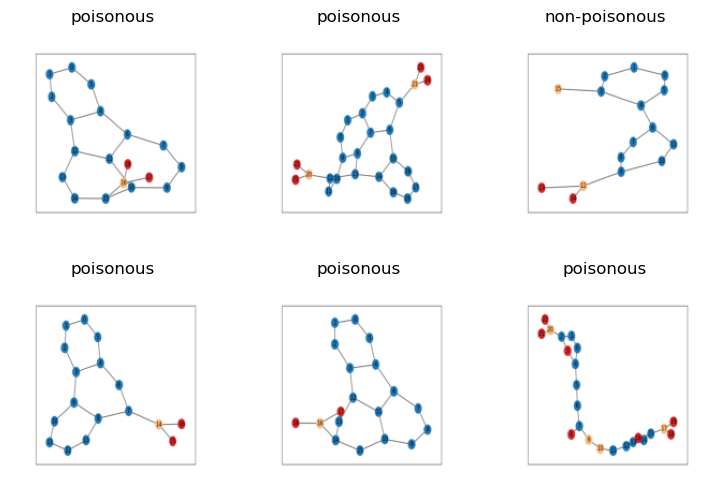

In [6]:
# Here we want to transform the train set images into a fastai dataloader
path = Path('train')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

### 2.2) Train the vision learner

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.121865,0.534620,0.133333,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.738295,0.641462,0.400000,00:02
1,0.592171,0.511291,0.200000,00:01
2,0.509104,0.550536,0.133333,00:03
3,0.434991,0.659060,0.133333,00:01
4,0.365630,0.807616,0.133333,00:01
5,0.306026,1.021804,0.200000,00:01
6,0.281546,1.178648,0.200000,00:01
7,0.247959,0.608795,0.133333,00:01
8,0.230093,0.639532,0.200000,00:01
9,0.204791,0.883662,0.200000,00:01


### 2.3) Accuracy of vision learner
Alright lets see how many of the test set properties do we accurately predict

In [8]:
directories = ['poisonous', 'non-poisonous']


correct = 0
for type in directories:
    images = os.listdir(f'test/{type}')
    for image in images:
        predicted_type, _, _ = learn.predict(f'test/{type}/{image}')
        if predicted_type == type:
            correct += 1


In [9]:
acc = correct/(len(os.listdir('test/poisonous'))+len(os.listdir('test/non-poisonous')))
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.868421052631579


Alright an accuracy of almost 90% with just a vision learner is quite impressive

## 3) GNN

Now lets apply a Graph Neural Network to this problem

### 3.1) batch the graphs in dataloaders

In [10]:
# batch them
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### 3.2) Define the GNN and the training loop

Here we define a simple 3 layer Graph Convolutional Neural Network

In [11]:
# %% Define GCN model


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=[64, 64, 64]):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels[0])
        self.conv2 = GCNConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = GCNConv(hidden_channels[1], hidden_channels[2])
        self.classifier = Linear(hidden_channels[2], dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # obtain convolved node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()  # Final GNN embedding space.

        # readout layer -> get molecular fingerprint
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels[-1]]
        # Apply a final (linear) classifier.
        out = self.classifier(x)

        return out, x


model = GCN()
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


Here we define the training loop. We used the ADAM optimizer and Crossentropy loss

In [12]:
# %% Train
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    running_loss = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        # Perform a single forward pass.
        out = model(data.x, data.edge_index, data.batch)[0]
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        running_loss += loss.item()


def test(loader):
    model.eval()

    running_correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)[0]
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        # Check against ground-truth labels.
        running_correct += int((pred == data.y).sum())
    # Derive ratio of correct predictions.
    return running_correct / len(loader.dataset)

In [13]:
for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    print(
        f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
   


Epoch: 001, Train Acc: 0.6933
Epoch: 002, Train Acc: 0.6933
Epoch: 003, Train Acc: 0.6933
Epoch: 004, Train Acc: 0.6933
Epoch: 005, Train Acc: 0.6933
Epoch: 006, Train Acc: 0.6933
Epoch: 007, Train Acc: 0.6933
Epoch: 008, Train Acc: 0.6933
Epoch: 009, Train Acc: 0.7400
Epoch: 010, Train Acc: 0.7733
Epoch: 011, Train Acc: 0.7733
Epoch: 012, Train Acc: 0.7467
Epoch: 013, Train Acc: 0.7533
Epoch: 014, Train Acc: 0.7400
Epoch: 015, Train Acc: 0.7600
Epoch: 016, Train Acc: 0.7467
Epoch: 017, Train Acc: 0.7667
Epoch: 018, Train Acc: 0.7667
Epoch: 019, Train Acc: 0.7733
Epoch: 020, Train Acc: 0.7667
Epoch: 021, Train Acc: 0.7600
Epoch: 022, Train Acc: 0.7800
Epoch: 023, Train Acc: 0.7733
Epoch: 024, Train Acc: 0.7733
Epoch: 025, Train Acc: 0.7800
Epoch: 026, Train Acc: 0.7733
Epoch: 027, Train Acc: 0.7800
Epoch: 028, Train Acc: 0.7800
Epoch: 029, Train Acc: 0.7600
Epoch: 030, Train Acc: 0.7867
Epoch: 031, Train Acc: 0.7667
Epoch: 032, Train Acc: 0.7800
Epoch: 033, Train Acc: 0.7733
Epoch: 034

In [14]:
test_acc = test(test_loader)
print(f'the GNN test set accuracy: {test_acc}')

the GNN test set accuracy: 0.6842105263157895


## 4) Conclusion

Remarkably the vision learner has a higher test set accuracy that the GNN. Now the vision learner is a much more complicated model: a pre-trained ResNet, than the GNN which was a simple 3-layer GNN. However, the fact that a vision learner did so well on a molecular property prediction application is quite remarkable